# Demonstration of Bootstrap Based Confidence Intervals

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Use the Boston Dataset

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()
x_total = pd.DataFrame(data=boston.data, columns=boston.feature_names)

In [3]:
x_total.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
y_total = pd.Series(boston.target, name='target')

In [5]:
y_total.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: target, dtype: float64

# Generate Train-test Split

In [6]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(x_total.index, random_state=0)
x_train, y_train = x_total.loc[train_index, :], y_total.loc[train_index]
x_test, y_test =  x_total.loc[test_index, :], y_total.loc[test_index]

# Generalization Error using a Bagging Estimator

In [7]:
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor


base_regressor = XGBRegressor(n_estimators=100, random_state=1234, objective='reg:squarederror')
bagging = BaggingRegressor(base_regressor, random_state=5, n_estimators=30, oob_score=True)

bagging = bagging.fit(x_train.values, y_train.values)

In [8]:
from sklearn.metrics import r2_score

test_preds = base_regressor.fit(x_train.values, y_train.values).predict(x_test.values)
test_error = r2_score(test_preds, y_test.values)
print("Test Set Error: {:.4f}".format(test_error))

Test Set Error: 0.6763


# Generate Boostrap Samples

In [9]:
from tqdm.notebook import tqdm

test_errors = []

bootstrap_predictions = []

for model in tqdm(bagging.estimators_):
    test_preds = model.predict(x_test.values)
    bootstrap_predictions.append(test_preds)
    test_score = r2_score(test_preds, y_test.values)
    test_errors.append(test_score)

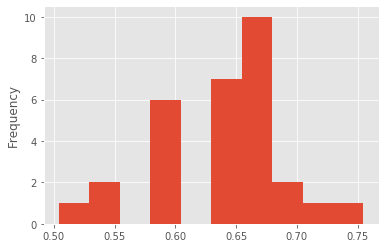

In [10]:
test_errors = pd.Series(test_errors, name='test_error_samples')
_ = test_errors.plot(kind='hist')

In [11]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

v = bs.bootstrap(test_errors.values, stat_func=bs_stats.mean)

# Generate Percentile Based Confidence Intervals

In [12]:
print("mean score: {:.4f}, lower_bound={:.4f}, upper_bound={:.4f}".format(
    v.value, v.lower_bound, v.upper_bound))

mean score: 0.6393, lower_bound=0.6203, upper_bound=0.6587


# Visualize Prediction Results for the Bootstrapped Models``

In [13]:
bootstrap_predictions = np.array(bootstrap_predictions)

bootstrap_predictions.shape

(30, 127)

In [14]:
bootstrapped_predictions = pd.DataFrame(data=bootstrap_predictions.T)

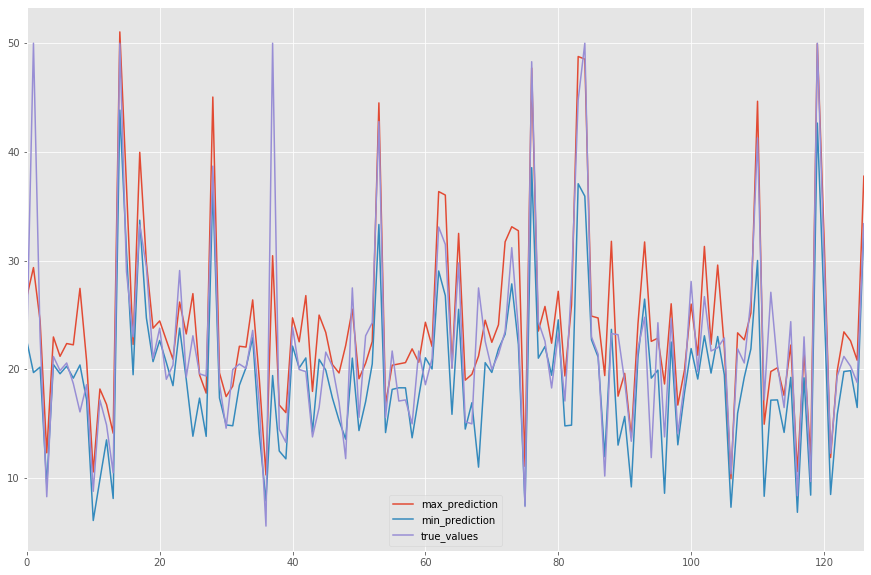

In [15]:
max_preds = bootstrapped_predictions.max(axis=1)
min_preds = bootstrapped_predictions.min(axis=1)
true_values = pd.Series(data=y_test.values)

pred_df = pd.concat({
    'max_prediction': max_preds, 
    'min_prediction': min_preds,
    'true_values': true_values,
}, axis=1)


_, ax = plt.subplots(1, 1, figsize=(15, 10))

_ = pred_df.plot(ax=ax)